<a href="https://colab.research.google.com/github/Guilherme-Coelh/IA-identificador-de-placas/blob/main/Trab2IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split #bib para divir o dataset

dataset_path = "/content/drive/MyDrive/dataset2"

transform = transforms.Compose([
    transforms.Resize((224, 224)), #redimensiona as imagens para 224x224 pixeis
    transforms.ToTensor(), #converte as imagens para o pytorch acessa-las
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #normalizacao das imagens para o ImageNet
])

dataset = datasets.ImageFolder(dataset_path, transform=transform)
size = len(dataset)
train_size = int(0.6 * size)
val_size = int(0.2 * size)
test_size = size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) #divide o dataset em 60% treino, 20% validacao e 20% teste, divide as imagens aleatoriamente



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("classe:", dataset.classes) #classes no drive


classe: ['Pare', 'PermitidoEstacionar', 'ProibidoEstacionar', 'ProibidoRetorno', 'SigaEmFrente']


In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.mobilenet_v2(pretrained = True) #escolhe o mobilenetv2
num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes) #ajuste fino do mobilenet, substituindo a ultima camada com uma nova que produz o output relacionado ao meu dataset

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for p in model.features.parameters(): #congela as camadas ja treinadas para treinar apenas a ultima camada adicionada
  p.requires_grad = False

In [ ]:
device = torch.device("cpu") #como nao funcionou o cuda, usou-se da cpu
model = model.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #funcao de loss
optimizer = optim.Adam(model.parameters(), lr=0.001) #otimizador


In [ ]:
num_epocas = 10

#vetores para armarezanar os valores de loss e acurarcias para plotar no grafico
train_losses = []
train_accuracys = []
val_losses = []
val_accuracys = []

for epoca in range(num_epocas): #divide o treino em epocas de 10

    model.train()
    running_loss = 0.0
    correto = 0
    total = 0

                    #treino

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) #move a classificacao para o cpu

        outputs = model(images) #output de predicao
        loss = criterion(outputs, labels) #calcula a loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) #calcula o numero de predicoes corretas e a loss
        _, predicted = torch.max(outputs, 1) #predicao da classe, escolhe a com maior probabilidade
        total += labels.size(0)
        correto += (predicted == labels).sum().item()



    train_accuracy = 100 * correto / total
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracys.append(train_accuracy)

                      # validacao
    model.eval()
    val_loss = 0.0
    correto = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) #calcula a loss da validacao
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correto += (predicted == labels).sum().item()


    val_accuracy = 100 * correto / total
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracys.append(val_accuracy)

    print(f"Epoca {epoca+1}/{num_epocas} | "
          f"loss treino: {train_loss:.4f}, acc treino: {train_accuracy:.2f}% | "
          f"loss val: {val_loss:.4f}, acc val: {val_accuracy:.2f}%")


Epoca 1/10 | loss treino: 1.4881, acc treino: 37.88% | loss val: 1.2523, acc val: 50.91%
Epoca 2/10 | loss treino: 0.8471, acc treino: 76.97% | loss val: 0.7263, acc val: 89.09%
Epoca 3/10 | loss treino: 0.5817, acc treino: 86.06% | loss val: 0.4768, acc val: 94.55%
Epoca 4/10 | loss treino: 0.4240, acc treino: 92.73% | loss val: 0.3913, acc val: 94.55%
Epoca 5/10 | loss treino: 0.3908, acc treino: 91.21% | loss val: 0.3274, acc val: 96.36%
Epoca 6/10 | loss treino: 0.3262, acc treino: 93.64% | loss val: 0.3288, acc val: 93.64%
Epoca 7/10 | loss treino: 0.2604, acc treino: 96.67% | loss val: 0.2642, acc val: 96.36%
Epoca 8/10 | loss treino: 0.2311, acc treino: 97.27% | loss val: 0.2614, acc val: 95.45%
Epoca 9/10 | loss treino: 0.2133, acc treino: 97.27% | loss val: 0.2199, acc val: 96.36%
Epoca 10/10 | loss treino: 0.1823, acc treino: 97.58% | loss val: 0.2126, acc val: 96.36%


In [ ]:
torch.save(model.state_dict(), 'mobilenet_finetuned.pt') #salva o modeloT


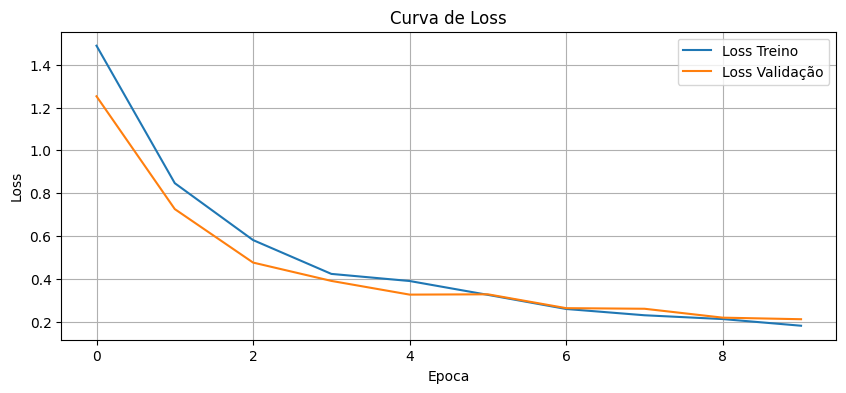

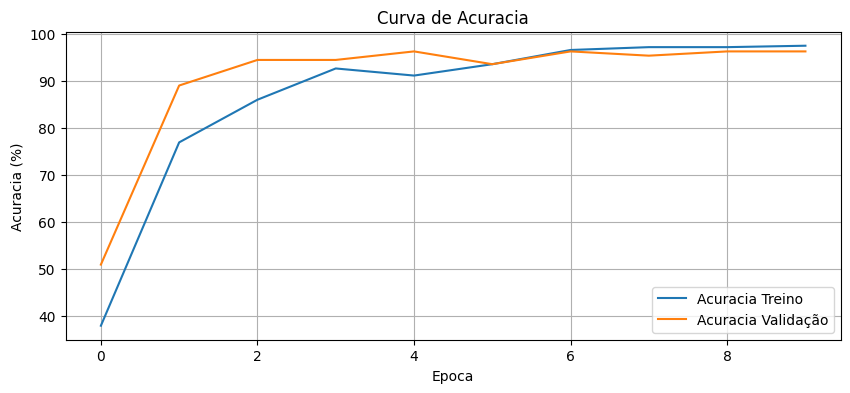

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Loss Treino')
plt.plot(val_losses, label='Loss Validação')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()
plt.grid()
plt.show()

# Acuracia
plt.figure(figsize=(10,4))
plt.plot(train_accuracys, label='Acuracia Treino')
plt.plot(val_accuracys, label='Acuracia Validação')
plt.xlabel('Epoca')
plt.ylabel('Acuracia (%)')
plt.title('Curva de Acuracia')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Relatório
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


                     precision    recall  f1-score   support

               Pare       1.00      0.96      0.98        25
PermitidoEstacionar       0.89      0.94      0.92        18
 ProibidoEstacionar       1.00      0.85      0.92        20
    ProibidoRetorno       0.90      1.00      0.95        27
       SigaEmFrente       1.00      1.00      1.00        20

           accuracy                           0.95       110
          macro avg       0.96      0.95      0.95       110
       weighted avg       0.96      0.95      0.95       110

